# Parametrization of a transient bubble shape

The aim of this notebook is to approximate the shape of an ellipsoidal bubble as a function polar angle and time. The shape is approximated for time interval $0\le \tilde{t}\le 20$.

In [1]:
import helper_module as hm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

%matplotlib inline

# make torch results reproducible and use double precision
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(42)
np.random.seed(42)

data_path = "../data/"
output_path = "../output/models/"

## Loading the training data

In [43]:
log_path = data_path + "wa18_l16/log.wa18_l16.csv"
log = hm.Logfile(log_path)
log.read_logfile(usecols=['time', 'x'])

# find iterations close to given time instances
times = np.linspace(0.0, 20.0, 21)
exact_times = []
facets = []
for time in times:
    row = log.find_closest("time", time)
    exact_times.append(row.time.values[0])
    plic_path = data_path + "wa18_l16/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
    facets.append(hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True))

Successfully read file ../data/wa18_l16/log.wa18_l16.csv
Successfully read file ../data/wa18_l16/plic_clean/plic_000000.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_048420.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_096850.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_145270.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_193700.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_242120.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_290550.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_338980.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_387400.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_435830.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_484250.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_532680.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_581110.pkl
Successfully read file ../data/wa18_l16/plic_clean/plic_629530.pkl
Succe

## Aspect ratio over time

In [44]:
aspect_ratio = []

for snap_shot in facets:
    min_x = np.min(snap_shot.facets.px.values)
    max_x = np.max(snap_shot.facets.px.values)
    min_y = np.min(snap_shot.facets.py.values)
    max_y = np.max(snap_shot.facets.py.values)
    aspect_ratio.append(2 * (max_x - min_x) / (max_y - min_y))

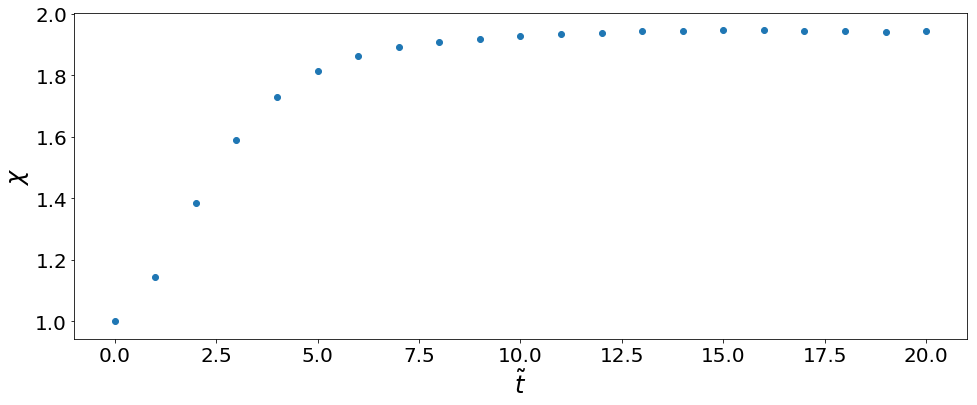

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

ax.scatter(exact_times, aspect_ratio)
ax.set_xlabel(r"$\tilde{t}$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\chi$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)

In [46]:
aspect_model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 3,
    "n_neurons" : 5,
    "activation" : torch.tanh,
    "batch_norm" : False
}

In [47]:
epochs = 2000

aspect_model = hm.SimpleMLP(**aspect_model_dict)
model_path = output_path + "/aspect_3layers_5nodes.pt"
aspect_model, losses = hm.training_loop(aspect_model, model_path,
                                        np.asarray(exact_times), np.asarray(aspect_ratio), None, epochs, 0.01)

100%|██████████| 2000/2000 [00:02<00:00, 682.72it/s]


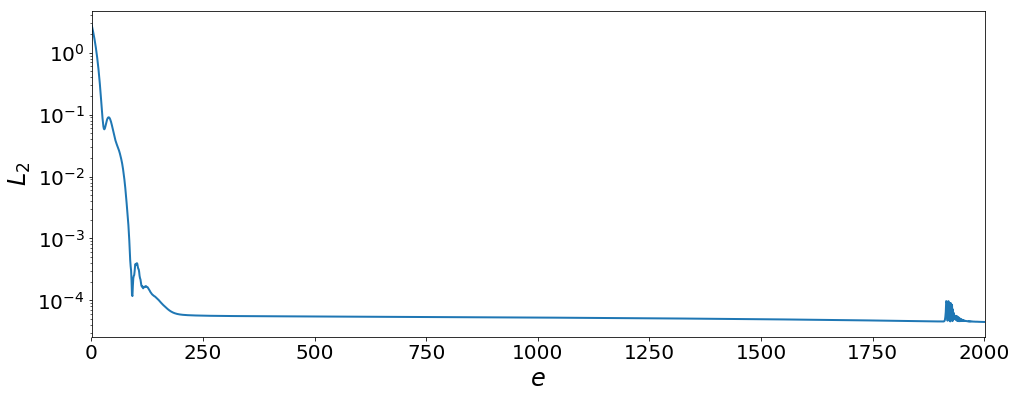

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

ax.plot(range(1, epochs+1), losses, ls="-", lw=2)
ax.set_xlabel("$e$", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("$L_2$", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)

In [55]:
model_path = output_path + "/aspect_3layers_5nodes.pt"
aspect_model.load_state_dict(torch.load(model_path))
t_eval_np = np.linspace(0.0, 20.0, 100)
t_eval = torch.from_numpy(t_eval_np.astype(np.float64)).unsqueeze_(-1)
aspect_pred = aspect_model.forward(t_eval).detach().squeeze().numpy()

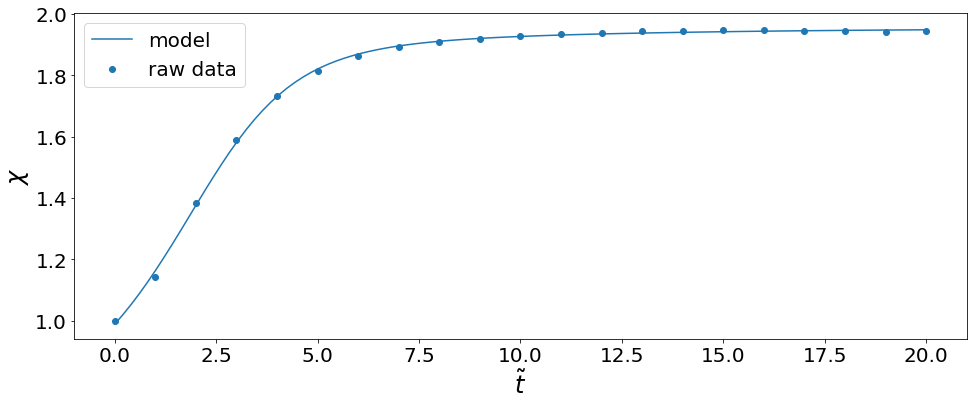

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

ax.scatter(exact_times, aspect_ratio, label="raw data")
ax.plot(t_eval_np, aspect_pred, label="model")
ax.set_xlabel(r"$\tilde{t}$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\chi$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

## Transfoming the raw training data using the aspect ratio

In [65]:
t_transform = torch.from_numpy(np.asarray(exact_times, dtype=np.float64)).unsqueeze_(-1)
aspect_pred = aspect_model.forward(t_transform).detach().squeeze().numpy()

prt_transformed = []
for snap_shot, chi, t in zip(facets, aspect_pred, exact_times):
    px, py = snap_shot.get_facets(polar=False)
    px_tr = px / chi**(1.0/3.0)
    py_tr = py * chi**(2.0/3.0)
    rad, phi = hm.transform_polar_2D(px_tr, py_tr)
    points = np.zeros((snap_shot.facets.shape[0], 3))
    points[:, 0] = phi
    points[:, 1] = rad
    points[:, 2] = t
    prt_transformed.append(points)

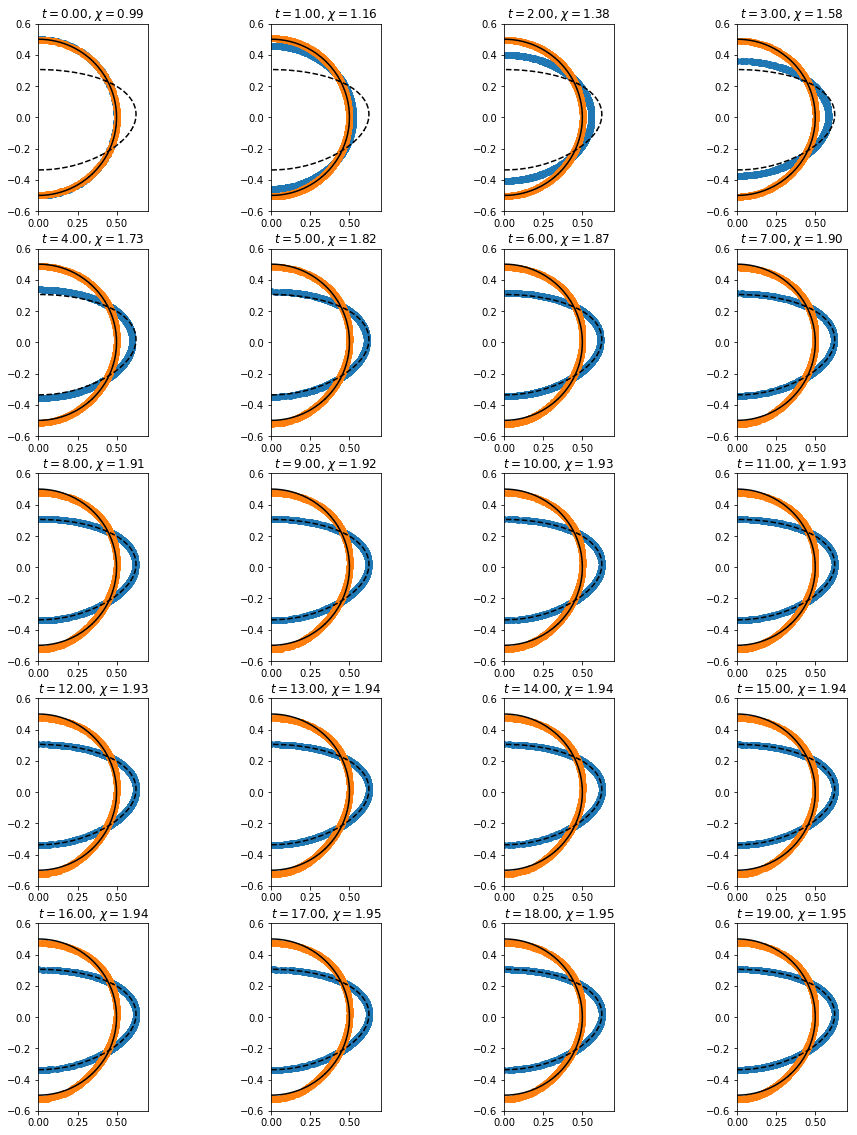

In [66]:
fig, axarr = plt.subplots(5, 4, figsize=(hm.figure_width, 20))

ind = [(i,j) for i in range(5) for j in range(4)]
px_0, py_0 = facets[0].get_facets(polar=False)
py_sort = np.argsort(py_0)
px_0 = px_0[py_sort]
py_0 = py_0[py_sort]

px_20, py_20 = facets[20].get_facets(polar=False)
py_sort = np.argsort(py_20)
px_20 = px_20[py_sort]
py_20 = py_20[py_sort]

for n, (i, j) in enumerate(ind):
    px, py = facets[n].get_facets(polar=False)
    axarr[i,j].scatter(px, py)
    px_tr = px / aspect_pred[n]**(1.0/3.0)
    py_tr = py * aspect_pred[n]**(2.0/3.0)
    axarr[i,j].plot(px_0, py_0, color="k", ls="-")
    axarr[i,j].plot(px_20, py_20, color="k", ls="--")
    axarr[i,j].scatter(px_tr, py_tr)
    axarr[i,j].set_xlim(0.0, 0.7)
    axarr[i,j].set_ylim(-0.6, 0.6)
    axarr[i,j].set_aspect("equal")
    axarr[i,j].set_title(r"$t={:2.2f}$, $\chi = {:2.2f}$".format(exact_times[n], aspect_pred[n]))

0.4965/0.5017/0.0053
0.4760/0.5253/0.0493
0.4770/0.5255/0.0485


Text(0,0.5,'$\\tilde{r}$')

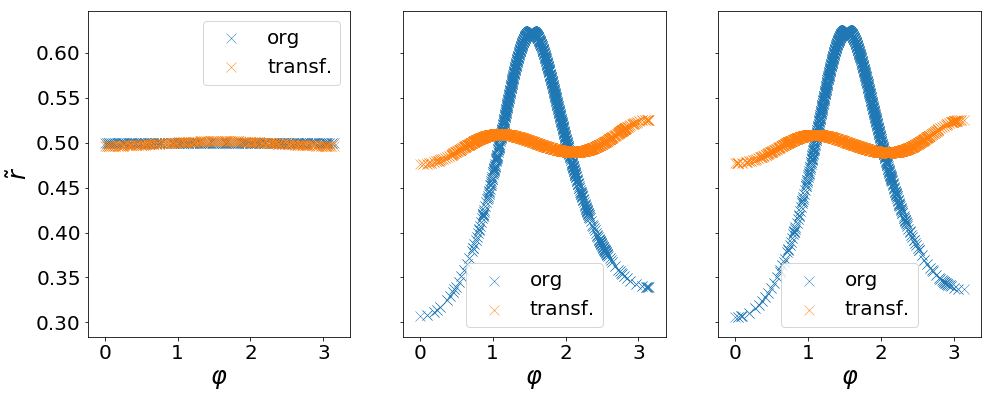

In [75]:
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 6), sharey=True)

for i, snap_shot in enumerate([facets[0], facets[10], facets[20]]):
    rad, phi = snap_shot.get_facets(polar=True)
    axarr[i].scatter(phi, rad, marker="x", lw=0.5, s=100, label="org")

for i, snap_shot in enumerate([prt_transformed[0], prt_transformed[10], prt_transformed[20]]):
    axarr[i].scatter(snap_shot[:,0], snap_shot[:,1], marker="x", lw=0.5, s=100, label="transf.")
    axarr[i].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    print("{:1.4f}/{:1.4f}/{:1.4f}".format(np.min(snap_shot[:,1]), np.max(snap_shot[:,1]),
                                           np.max(snap_shot[:,1]) - np.min(snap_shot[:,1])))
    
axarr[0].set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)